# Method 1: Vector Space Retrieval TF/IDF (simple)

Represent both the document and the query by a weight vector in the m-dimensional keyword space assigning non-binary weights and then determine their distance in the m-dimensional keyword space. 

It is based on a vector space retrieval (VSR) model. For testing the model is used on a simple document collection with about 150 documents in file *blabla.txt*:


  DocID | Document Text
  ------|------------------
  1     | I think therefore I am
  2     | Climate change is a hoax
  3     | Fakenews
  4     | More beautiful life
  5     | Jules and Mr. Gilleron are very friendly
  6     | Road to Minor improvement
  7     | In love with the Rolex meeting rooms
  8     | The important thing is to laugh
  9     | A small step for man but a big step for humanity
 ...    | ...
 160     | The music is too loud for my ears.
 
 
 In information retrieval, tf–idf, TF\*IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today. For more info: [link](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
 
 Properties: 
 - Ranking of documents according to similarity value
 - Documents can be retrieved even if they don't contain some query keyword
 - fast to compute

In [63]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from operator import itemgetter
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()

# Tokenize, stem a document
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens if word not in stopwords.words('english')])

# Read a list of documents from a file. Each line in a file is a document
with open("blabla.txt", encoding='utf8') as f:
    content = f.readlines()
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]

# create the vocabulary
vocabulary = list(set([item for sublist in documents for item in sublist]))
vocabulary.sort()
print('Vocabulary in the documents\n ------------------------------\n', vocabulary)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Vocabulary in the documents
 ------------------------------
 ['100', '20000', '7am', 'a', 'aaron', 'abl', 'accept', 'address', 'ador', 'afternoon', 'ahead', 'air', 'all', 'amaz', 'ancestor', 'angel', 'anoth', 'answer', 'anyth', 'apolog', 'appreci', 'are', 'around', 'ask', 'ate', 'avail', 'away', 'bad', 'bag', 'basebal', 'bean', 'beauti', 'best', 'big', 'bigger', 'birthday', 'black', 'blind', 'block', 'blow', 'board', 'bodi', 'book', 'boot', 'bore', 'boston', 'bring', 'brother', 'brush', 'bu', 'bueno', 'call', 'can', 'candl', 'car', 'care', 'carelessli', 'cash', 'cat', 'catch', 'chang', 'checkin', 'children', 'chime', 'circl', 'class', 'classgroup', 'climat', 'clock', 'close', 'closest', 'coffe', 'color', 'come', 'commit', 'committe', 'common', 'commut', 'corn'

In [64]:
# Retrieval oracle 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

Now, for the query $Q$ = $love$, here the top ranked documents according to the TF/IDF rank using the scikit-learn library.

In [65]:
ret_ids = search_vec_sklearn('Jules loves watching TV with friends', features)
print('Found correspondances:', len(ret_ids))
print('----------------------------')
for i, v in enumerate(ret_ids):
    print(original_documents[v])

Found correspondances: 3
----------------------------
Watching TV and movies is something that most people enjoy
I will meet with my friends on Friday.
Jules and Mr. Gilleron are very friendly


# Method 2: Vector space retrieval TF/IDF + Query expension

Implementation and test of [Rocchio's method](https://en.wikipedia.org/wiki/Rocchio_algorithm) for user relevance feedback. Like many other retrieval systems, the Rocchio feedback approach was developed using the Vector Space Model. The algorithm is based on the assumption that most users have a general conception of which documents should be denoted as relevant or non-relevant. Therefore, the user's search query is revised to include an arbitrary percentage of relevant and non-relevant documents as a means of increasing the search engine's recall, and possibly the precision as well. The number of relevant and non-relevant documents allowed to enter a query is dictated by the weights of the a, b, c variables listed below in the Algorithm section.

Let the set of relevant documents to be $D_r $ and the set of non-relevant documents to be $D_{nr}$. Then the modified query  $\vec{q_m}$  according to the Rocchio method is:

\begin{equation}
\vec{q_m} = \alpha \vec{q_0} + \frac{\beta}{|D_r|} \sum_{\vec{d_j} \in D_r} \vec{d_j} - \frac{\gamma}{|D_{nr}|} \sum_{\vec{d_j} \in D_{nr}} \vec{d_j}
\end{equation}
In the Rocchio algorithm negative term weights are ignored. This means, for the negative term weights in $\vec{q_m}$, we set them to be 0.

Properties:

- System adds query terms to user query
- Use of the top $k$ documents to enriche the initial querry
- Modified queries are complex $\rightarrow$ expensive processing

In [66]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
import numpy as np

stemmer = PorterStemmer()

# Tokenize, stem a document
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

# Read a list of documents from a file. Each line in a file is a document
#with open("bread.txt") as f:
with open("blabla.txt", encoding = 'utf8') as f:
    content = f.readlines()
#original_documents = [x.decode('utf-8').strip() for x in content] # for python2
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]

# create the vocabulary
vocabulary = set([item for sublist in documents for item in sublist])
vocabulary = [word for word in vocabulary if word not in stopwords.words('english')]
vocabulary.sort()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
# compute IDF, storing idf values in a dictionary
def idf_values(vocabulary, documents):
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        idf[term] = math.log(num_documents/sum(term in document for document in documents), math.e)
    return idf

# Function to generate the vector for a document (with normalisation)
def vectorize(document, vocabulary, idf):
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term] * counts[term]/max_count
    return vector

# Function to compute cosine similarity
def cosine_similarity(v1,v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/math.sqrt(sumxx*sumyy)
    return result

def vectorize_query(query, vocabulary, idf):
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    return query_vector
    
def search_vec(query, k):
    query_vector = vectorize_query(query, vocabulary, idf)
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    ans = []
    indices = []
    for i in range(min(k,len(original_documents))):
        ans.append(original_documents[scores[i][1]])
        indices.append(scores[i][1])
    return ans, indices, query_vector

# Compute IDF values and vectors
idf = idf_values(vocabulary, documents)
document_vectors = [vectorize(s, vocabulary, idf) for s in documents]

Shaping the modified vector in a direction closer, or farther away, from the original query, related documents, and non-related documents.

In [68]:
def expand_query(relevant_doc_vecs, non_relevant_doc_vecs, query_vector, alpha, beta, gamma):

    num_rel = len(relevant_doc_vecs)
    num_non_rel = len(non_relevant_doc_vecs)
    
    # Compute the first term in the Rocchio equation
    norm_query_vector = query_vector*alpha
    
    # Compute the second term in the Rocchio equation
    norm_sum_relevant = [beta*sum(x)/num_rel for x in zip(*relevant_doc_vecs)]
    
    # Compute the last term in the Rocchio equation
    norm_sum_non_relevant = [-gamma*sum(x)/num_non_rel for x in zip(*non_relevant_doc_vecs)]
    
    # Sum all the terms
    modified_query_vector = [sum(x) for x in zip(norm_sum_relevant, norm_sum_non_relevant, norm_query_vector)]
    
    # Ignore negative elements
    modified_query_vector = [x if x>0 else 0 for x in modified_query_vector]
    return modified_query_vector

In [69]:
ans, result_doc_ids, query_vector = search_vec("Jules loves paragliding", 5)
for i in range(len(ans)):
    print(i,ans[i])

0 I love being around you.
1 Jules and Mr. Gilleron are very friendly
2 In love with the Rolex meeting rooms
3 Emily is similar to James. They both love to dance.
4 I think therefore I am


If we fix that the first 3 elements resulting from the initial query are relevant to enrich the querry then we have the following results:

In [70]:
# list of indices marked as relevant
# suppose first three documents were relevant and the rest were irrelevant.
relevant_indices = [0,1,2]
non_relevant_indices = [i for i in range(3, len(ans))]

relevant_doc_ids = [result_doc_ids[i] for i in relevant_indices]
non_relevant_doc_ids = [result_doc_ids[i] for i in non_relevant_indices]

relevant_doc_vecs = [document_vectors[i] for i in relevant_doc_ids]
non_relevant_doc_vecs = [document_vectors[i] for i in non_relevant_doc_ids]

expanded_query = expand_query(relevant_doc_vecs, non_relevant_doc_vecs, query_vector, 1, 1, 1)

new_query = ' '.join([vocabulary[i] for i, val in enumerate(expanded_query) if val>0])

new_ans , not_important_now, idontcare_anymore = search_vec(new_query, 10)

print('Modified query: ', new_query)
new_ans

Modified query:  around friendli gilleron jule love meet mr rolex room veri


['Jules and Mr. Gilleron are very friendly',
 'In love with the Rolex meeting rooms',
 'I love being around you.',
 'Are you from around here?',
 'Mrs. Juarez and Mr. Smith are dancing gracefully.',
 'It is nice to meet you',
 'I will meet with my friends on Friday.',
 'Misha walked and looked around.',
 'Where is the changing room?',
 'The room is too noisy.']

# Method 3: Word embeddings
In natural language processing (NLP), word embedding is a term used for the representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning. Word embeddings can be obtained using a set of language modeling and feature learning techniques where words or phrases from the vocabulary are mapped to vectors of real numbers. Conceptually it involves the mathematical embedding from space with many dimensions per word to a continuous vector space with a much lower dimension.

For this method, we would train word embeddings using a state-of-the-art embeddings [library fastText](https://ai.facebook.com/tools/fasttext) (facebook).

Note that it is only available on linux and iOS :( $\rightarrow$ Virtual Machine or Google Colab

In [71]:
#if necessary 
!pip install fasttext

In [72]:
import fasttext
import numpy as np

In [73]:
model = fasttext.train_unsupervised('blabla.txt', model = 'cbow')
vocabulary = model.words
word_embeddings = np.array([model[word] for word in vocabulary])


### Visualization of the Embeddings

Visualization the generated embeddings using t-SNE (T-Distributed Stochastic Neighbouring Entities). t-SNE is a dimensionality reduction algorithm which is well suited for such visualization tasks.


In [74]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init = 'pca') 
vis_data = tsne.fit_transform(word_embeddings)

[t-SNE] Computing 48 nearest neighbors...
[t-SNE] Indexed 49 samples in 0.000s...
[t-SNE] Computed neighbors for 49 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 49 / 49
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.269264
[t-SNE] KL divergence after 1000 iterations: 0.704208


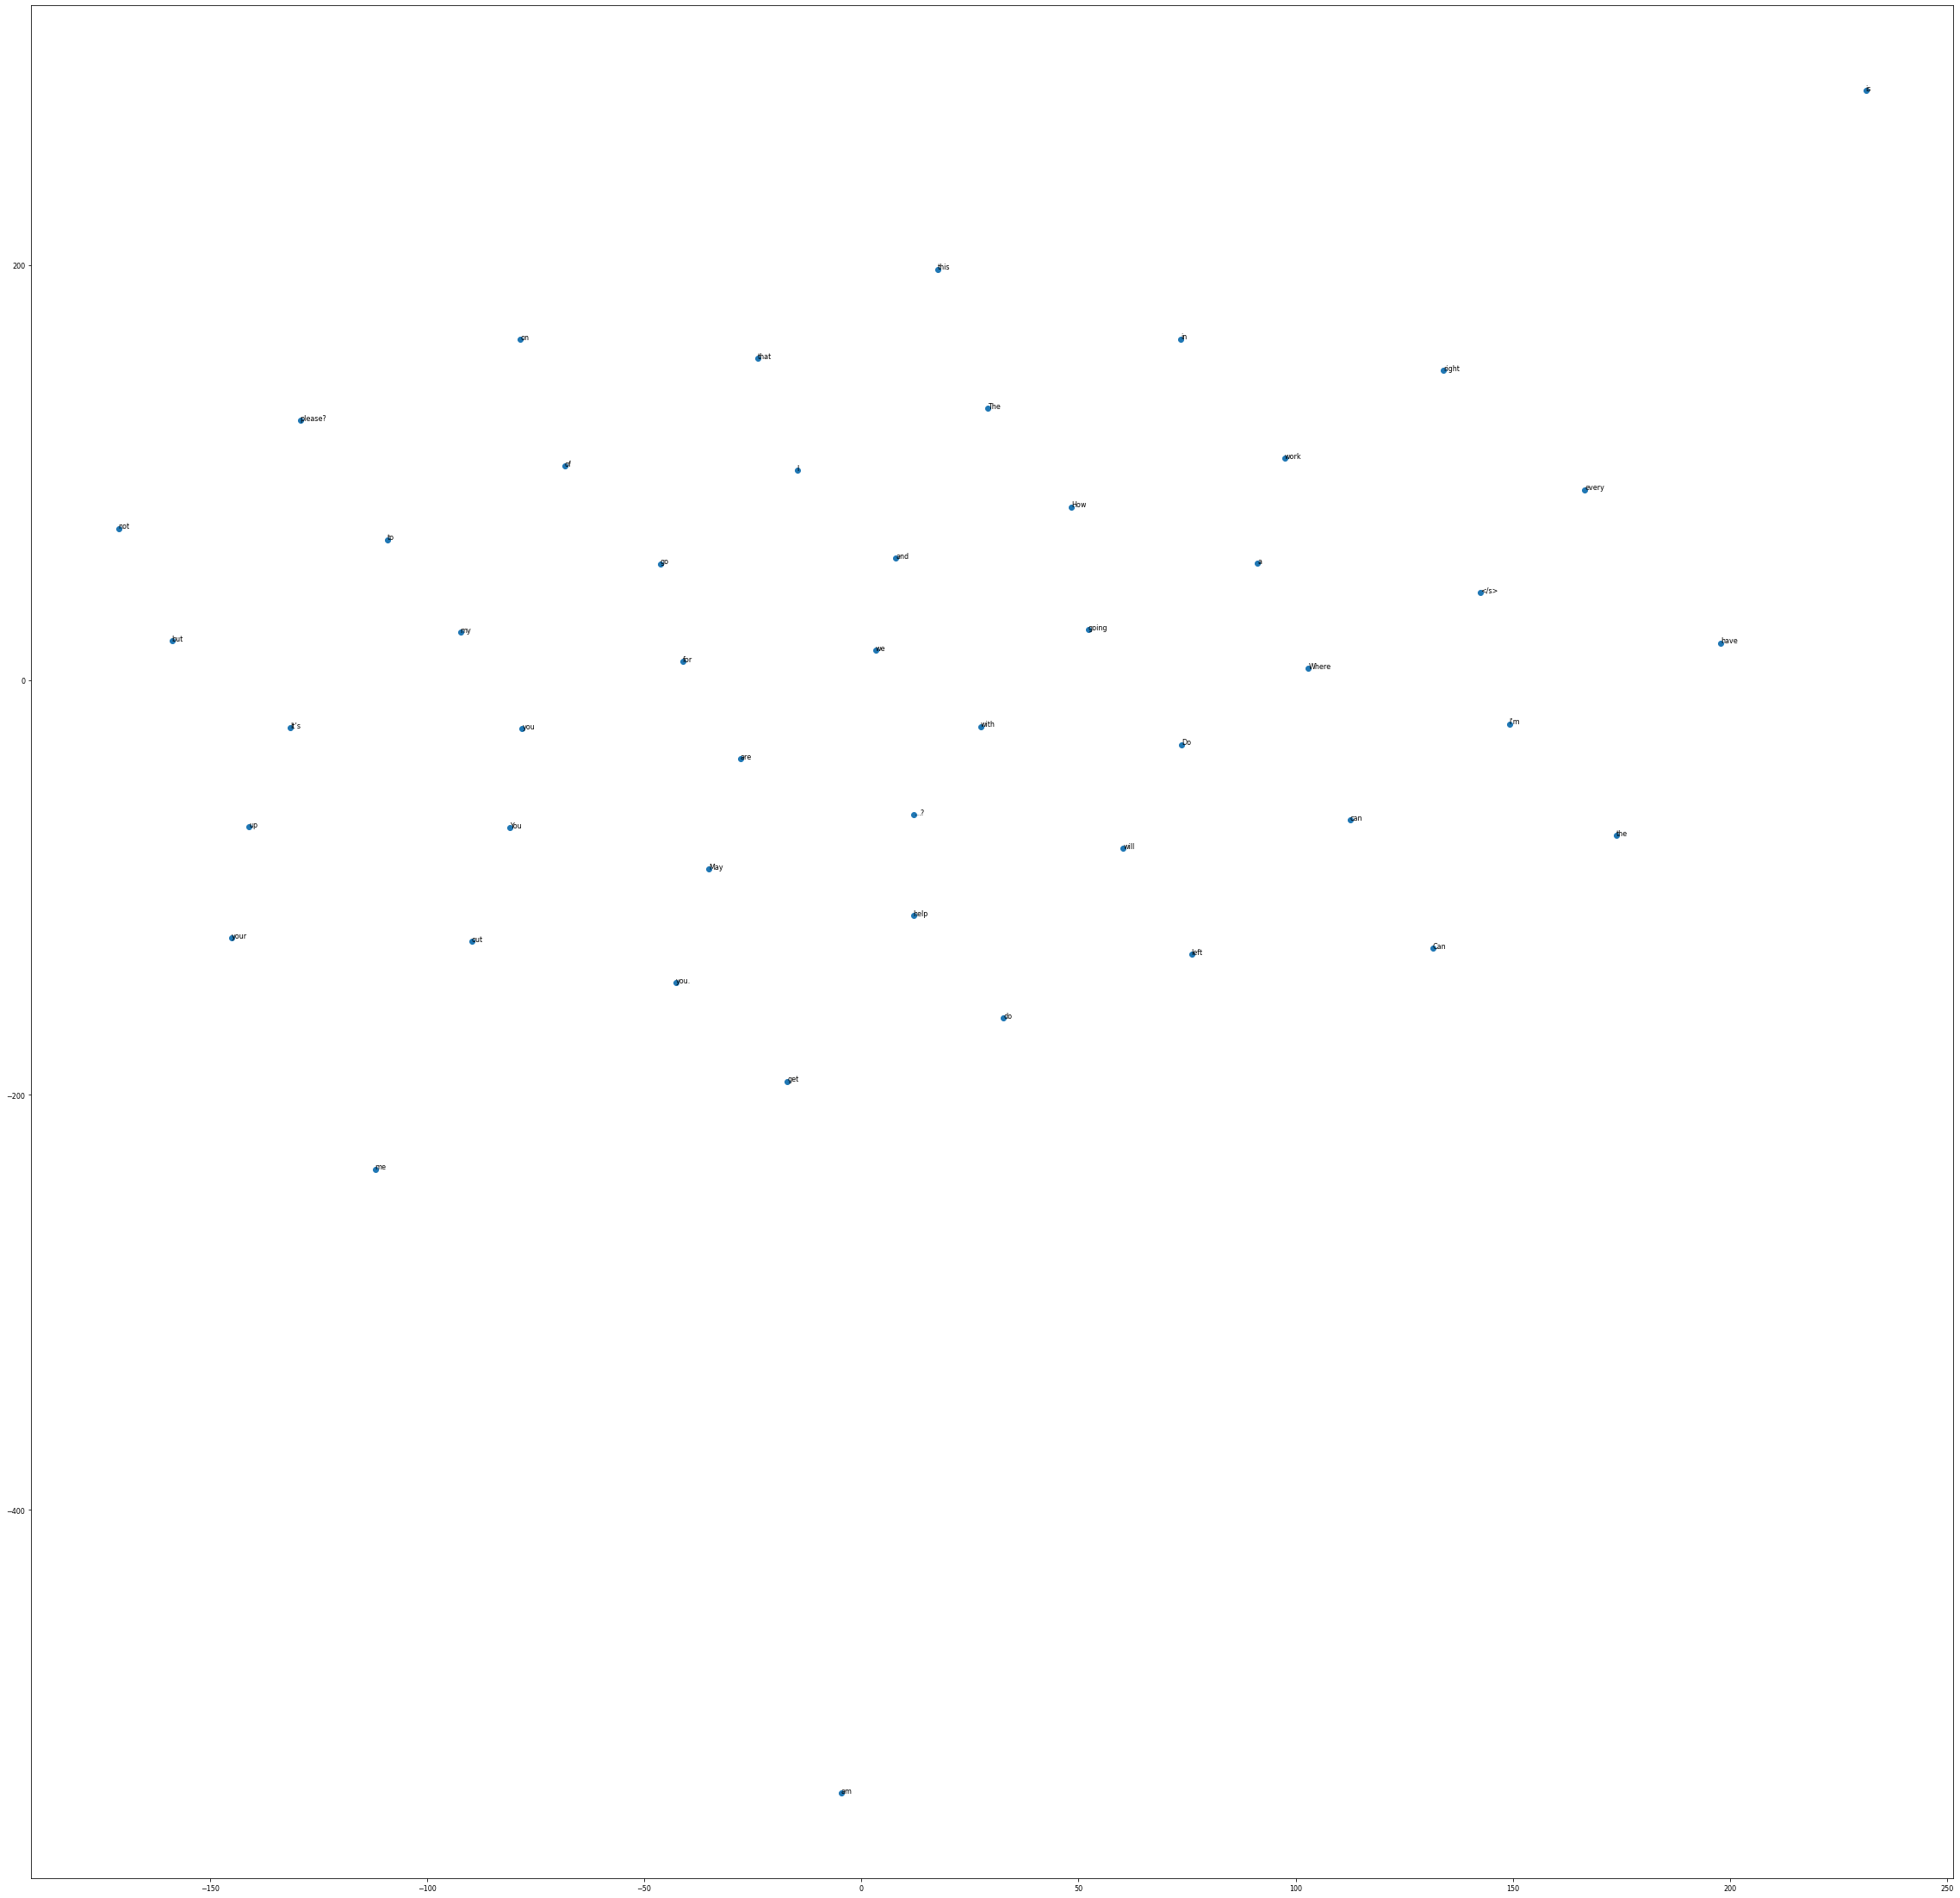

In [75]:
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(40, 40)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()